<a href="https://colab.research.google.com/github/elvinasari/pneumonia-with-cnn/blob/main/pneumonia_fiks_banget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================== 1. KAITKAN DENGAN GOOGLE DRIVE =====================
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===================== 2. IMPORT LIBRARY =====================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import cv2
from PIL import Image
import random
import glob
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
# Ganti sesuai dengan path folder dataset kamu di Google Drive
base_path = '/content/drive/MyDrive/chest_xray_dataset'

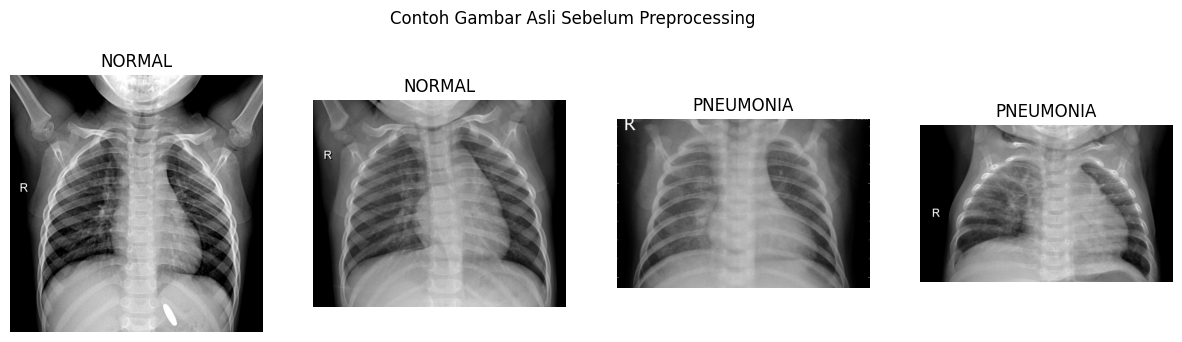

In [ ]:
# ===================== 4. TAMPILKAN CONTOH CITRA =====================
import glob

normal_dir = os.path.join(base_path, 'NORMAL')
pneumonia_dir = os.path.join(base_path, 'PNEUMONIA')

sample_normal = glob.glob(os.path.join(normal_dir, '*.jpeg'))
sample_pneumonia = glob.glob(os.path.join(pneumonia_dir, '*.jpeg'))

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i, img_path in enumerate(random.sample(sample_normal, 2) + random.sample(sample_pneumonia, 2)):
    img = Image.open(img_path).convert('RGB')
    axes[i].imshow(img)
    axes[i].set_title("NORMAL" if "NORMAL" in img_path else "PNEUMONIA")
    axes[i].axis('off')
plt.suptitle("Contoh Gambar Asli Sebelum Preprocessing")
plt.show()

In [ ]:
# ===================== 5. PEMBAGIAN DATASET OTOMATIS =====================
from sklearn.model_selection import train_test_split
import shutil

data_dir = base_path  # karena folder NORMAL & PNEUMONIA langsung ada di base_path
output_dir = os.path.join(base_path, 'split')  # agar hasil tidak tercampur dengan asli

classes = ['NORMAL', 'PNEUMONIA']
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'test', cls, img))

print("✅ Dataset berhasil dibagi menjadi train/val/test di folder 'split'")

✅ Dataset berhasil dibagi menjadi train/val/test di folder 'split'


In [ ]:
# ===================== 6. PREPROCESSING DATASET DARI FOLDER SPLIT =====================
split_dir = os.path.join(base_path, 'split')  # folder hasil split otomatis
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # rotasi acak dalam derajat
    width_shift_range=0.1,    # geser horizontal acak
    height_shift_range=0.1,   # geser vertikal acak
    shear_range=0.1,          # shearing
    zoom_range=0.2,           # zoom in/out
    horizontal_flip=True,     # flip horizontal acak
    brightness_range=[0.8,1.2], # ubah kecerahan
    fill_mode='nearest'       # cara mengisi piksel kosong
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4687 images belonging to 2 classes.
Found 586 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


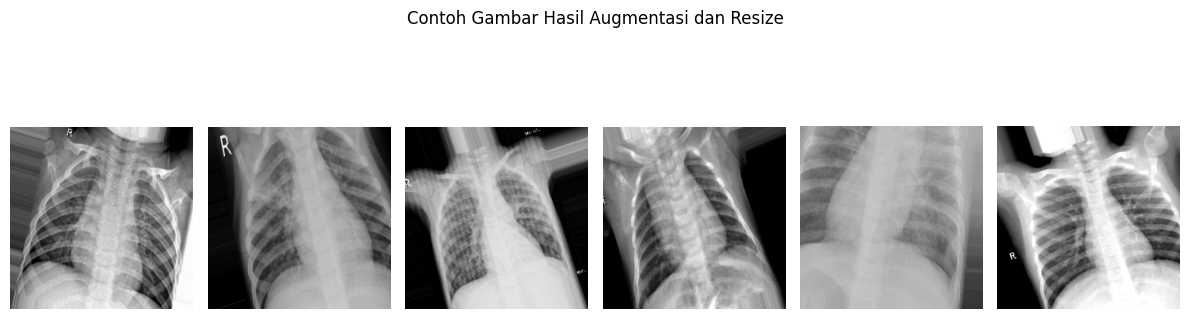

In [ ]:
# ===================== 7. TAMPILKAN HASIL AUGMENTASI DAN RESIZE =====================
images, _ = next(train_gen)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Contoh Gambar Hasil Augmentasi dan Resize")
plt.tight_layout()
plt.show()

In [ ]:
# 6. Bangun Model VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           12

 Total params: 21,170,497 (80.76 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import pathlib
import re

# Ganti sesuai jenis model
model_type = 'VGG16'

# Buat foldernya
base_dir = pathlib.Path(f'/content/drive/MyDrive/ModelCNN/{model_type}')
base_dir.mkdir(parents=True, exist_ok=True)

# Cari file model yang sudah ada
existing_models = list(base_dir.glob(f'model_{model_type.lower()}_*.h5'))

# Ambil nomor urutan terakhir
model_nums = []
for m in existing_models:
    match = re.search(rf'model_{model_type.lower()}_(\d+).h5', str(m))
    if match:
        model_nums.append(int(match.group(1)))

next_num = max(model_nums) + 1 if model_nums else 1

# Path model baru
model_filename = f'model_{model_type.lower()}_{next_num}.h5'
model_path = str(base_dir / model_filename)

# Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]

print(f"🔄 Model akan disimpan sebagai: {model_filename}")

🔄 Model akan disimpan sebagai: model_vgg16_1.h5


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',     # Pantau loss validasi
        patience=3,             # Stop kalau tidak membaik setelah 3 epoch
        restore_best_weights=True  # Ambil bobot terbaik sebelum overfitting
    ),
    ModelCheckpoint(
        'model_1_pneumonia_vgg16.h5',  # Simpan model terbaik ke file ini
        save_best_only=True,         # Simpan hanya model terbaik
        monitor='val_loss',          # Berdasarkan nilai val_loss
        mode='min',                  # Cari nilai terkecil dari loss
        verbose=1                    # Tampilkan info saat menyimpan
    )
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.7697 - loss: 1.0293
Epoch 1: val_loss improved from inf to 0.59140, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 156s 956ms/step - accuracy: 0.7701 - loss: 1.0280 - val_accuracy: 0.8976 - val_loss: 0.5914
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.8996 - loss: 0.5832
Epoch 2: val_loss improved from 0.59140 to 0.44414, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 127s 857ms/step - accuracy: 0.8996 - loss: 0.5831 - val_accuracy: 0.9454 - val_loss: 0.4441
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9169 - loss: 0.5006
Epoch 3: val_loss improved from 0.44414 to 0.41415, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 130s 879ms/step - accuracy: 0.9169 - loss: 0.5005 - val_accuracy: 0.9317 - val_loss: 0.4142
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9214 - loss: 0.4438
Epoch 4: val_loss improved from 0.41415 to 0.38490, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 129s 879ms/step - accuracy: 0.9214 - loss: 0.4437 - val_accuracy: 0.9266 - val_loss: 0.3849
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9277 - loss: 0.4009
Epoch 5: val_loss did not improve from 0.38490
147/147 ━━━━━━━━━━━━━━━━━━━━ 131s 894ms/step - accuracy: 0.9277 - loss: 0.4009 - val_accuracy: 0.8993 - val_loss: 0.4063
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9350 - loss: 0.3751
Epoch 6: val_loss improved from 0.38490 to 0.36950, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 129s 880ms/step - accuracy: 0.9349 - loss: 0.3751 - val_accuracy: 0.9130 - val_loss: 0.3695
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9367 - loss: 0.3491
Epoch 7: val_loss did not improve from 0.36950
147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 852ms/step - accuracy: 0.9367 - loss: 0.3490 - val_accuracy: 0.8925 - val_loss: 0.4038
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.9272 - loss: 0.3472
Epoch 8: val_loss improved from 0.36950 to 0.29772, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 130s 884ms/step - accuracy: 0.9273 - loss: 0.3471 - val_accuracy: 0.9403 - val_loss: 0.2977
Epoch 9/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9446 - loss: 0.3025
Epoch 9: val_loss improved from 0.29772 to 0.27041, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 856ms/step - accuracy: 0.9446 - loss: 0.3026 - val_accuracy: 0.9539 - val_loss: 0.2704
Epoch 10/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9425 - loss: 0.3130
Epoch 10: val_loss did not improve from 0.27041
147/147 ━━━━━━━━━━━━━━━━━━━━ 128s 866ms/step - accuracy: 0.9425 - loss: 0.3130 - val_accuracy: 0.9283 - val_loss: 0.2954
Epoch 11/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.9425 - loss: 0.2885
Epoch 11: val_loss did not improve from 0.27041
147/147 ━━━━━━━━━━━━━━━━━━━━ 128s 869ms/step - accuracy: 0.9424 - loss: 0.2885 - val_accuracy: 0.9283 - val_loss: 0.2782
Epoch 12/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9410 - loss: 0.2752
Epoch 12: val_loss improved from 0.27041 to 0.23606, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 127s 865ms/step - accuracy: 0.9410 - loss: 0.2753 - val_accuracy: 0.9590 - val_loss: 0.2361
Epoch 13/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9335 - loss: 0.2851
Epoch 13: val_loss did not improve from 0.23606
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 826ms/step - accuracy: 0.9335 - loss: 0.2851 - val_accuracy: 0.9317 - val_loss: 0.2696
Epoch 14/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9313 - loss: 0.2786
Epoch 14: val_loss did not improve from 0.23606
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 829ms/step - accuracy: 0.9313 - loss: 0.2785 - val_accuracy: 0.9386 - val_loss: 0.2521
Epoch 15/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.9450 - loss: 0.2538
Epoch 15: val_loss improved from 0.23606 to 0.22785, saving model to /content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 127s 862ms/step - accuracy: 0.9449 - loss: 0.2538 - val_accuracy: 0.9522 - val_loss: 0.2278


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9479 - loss: 0.2244
Akurasi Test Set: 94.38%
Loss Test Set: 0.2289
587/587 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


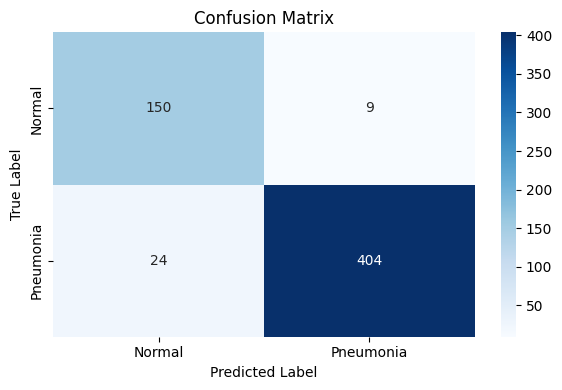

              precision    recall  f1-score   support

      Normal       0.86      0.94      0.90       159
   Pneumonia       0.98      0.94      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.94      0.93       587
weighted avg       0.95      0.94      0.94       587



In [ ]:
import os
os.makedirs('/content/drive/MyDrive/ModelCNN', exist_ok=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi model di test set
loss, acc = model.evaluate(test_gen)
print(f"Akurasi Test Set: {acc * 100:.2f}%")
print(f"Loss Test Set: {loss:.4f}")

# Prediksi
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Normal', 'Pneumonia']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# ✅ Simpan ke Google Drive
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ModelCNN/evaluasi_confusion_matrix.png', dpi=300)
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))

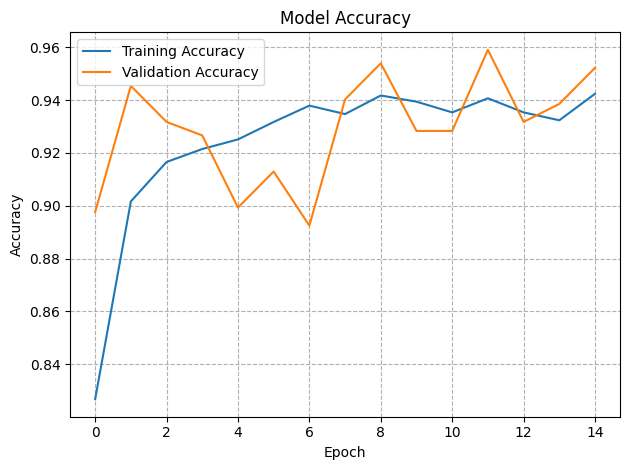

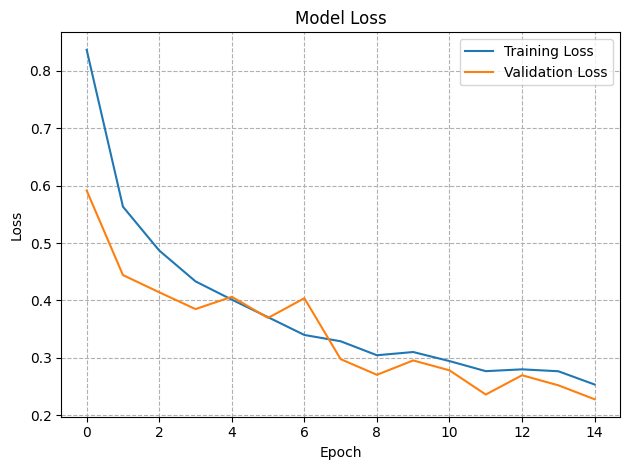

In [ ]:
import matplotlib.pyplot as plt
import os

# Pastikan Drive sudah di-mount dan folder sudah dibuat
drive_path = '/content/drive/MyDrive/ModelCNN'
os.makedirs(drive_path, exist_ok=True)

# Plot Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.savefig(f'{drive_path}/training_accuracy.png', dpi=300)
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.savefig(f'{drive_path}/training_loss.png', dpi=300)
plt.show()

In [ ]:
def predict_image(img_path, show_gradcam=True, save_to_drive=False,
                  drive_dir='/content/drive/MyDrive/ModelCNN/Prediksi'):
    """
    Predict gambar baru + (opsional) overlay Grad‑CAM & simpan hasil.

    Parameters
    ----------
    img_path : str
        Lokasi file gambar.
    show_gradcam : bool, default True
        Jika True, tampilkan heat‑map Grad‑CAM.
    save_to_drive : bool, default False
        Jika True, simpan PNG hasil ke Google Drive.
    drive_dir : str
        Folder tujuan di Drive jika save_to_drive=True.
    """
    # --- 1. Load citra asli (RGB) ----
    pil_img  = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    arr_norm = tf.keras.preprocessing.image.img_to_array(pil_img) / 255.0
    arr_batch = np.expand_dims(arr_norm, axis=0)

    # --- 2. Prediksi ---
    prob = model.predict(arr_batch, verbose=0)[0][0]
    label = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'

    # --- 3. Grad‑CAM (jika diminta) ---
    if show_gradcam:
       heat = get_gradcam(model, arr_batch)
       heat_uint8 = np.uint8(255 * heat)
       heat_color = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)
       img_bgr    = cv2.cvtColor(np.uint8(pil_img), cv2.COLOR_RGB2BGR)
       overlay    = cv2.addWeighted(img_bgr, 0.6, heat_color, 0.4, 0)
       display_img = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    else:
       display_img = np.uint8(pil_img)


    # --- 4. Plot ---
    plt.figure(figsize=(4,4))
    plt.imshow(display_img)
    plt.title(f"{label}  (p={prob:.2f})")
    plt.axis('off')
    plt.show()

    # --- 5. Simpan ke Drive (opsional) ---
    if save_to_drive:
        import os, pathlib
        pathlib.Path(drive_dir).mkdir(parents=True, exist_ok=True)
        out_path = os.path.join(drive_dir,
                    f"{label.lower()}_{pathlib.Path(img_path).stem}_p{prob:.2f}.png")
        cv2.imwrite(out_path, cv2.cvtColor(display_img, cv2.COLOR_RGB2BGR))
        print(f"Hasil disimpan ke: {out_path}")

In [ ]:
def get_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else np.zeros_like(cam)
    cam = cv2.resize(cam, IMG_SIZE)
    return cam

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


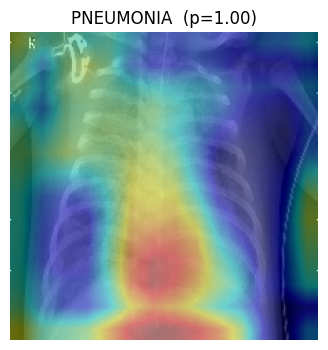

Hasil disimpan ke: /content/drive/MyDrive/ModelCNN/Prediksi/pneumonia_person1000_bacteria_2931_p1.00.png


In [ ]:
predict_image('/content/drive/MyDrive/person1000_bacteria_2931.jpeg', save_to_drive=True)

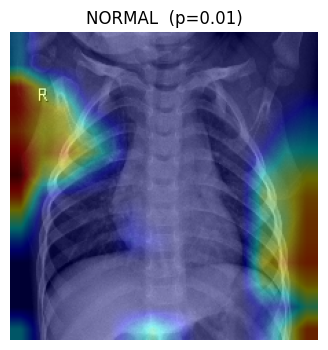

Hasil disimpan ke: /content/drive/MyDrive/ModelCNN/Prediksi/normal_normal_p0.01.png


In [ ]:
# Tampilkan + simpan PNG ke Google Drive
predict_image('/content/drive/MyDrive/normal.jpeg', save_to_drive=True)

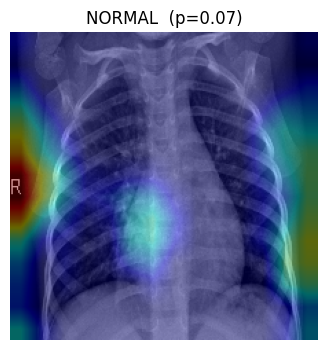

Hasil disimpan ke: /content/drive/MyDrive/ModelCNN/Prediksi/normal_person104_virus_191_p0.07.png


In [ ]:
# Tampilkan + simpan PNG ke Google Drive
predict_image('/content/drive/MyDrive/chest_xray_dataset/PNEUMONIA/person104_virus_191.jpeg', save_to_drive=True)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


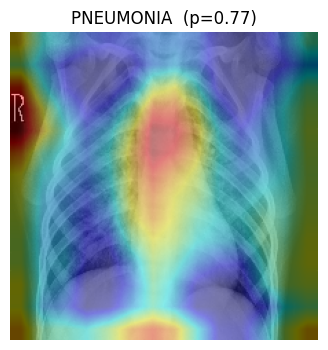

Hasil disimpan ke: /content/drive/MyDrive/ModelCNN/Prediksi/pneumonia_person1084_virus_1796_p0.77.png


In [ ]:
predict_image('/content/drive/MyDrive/chest_xray_dataset/PNEUMONIA/person1084_virus_1796.jpeg' , save_to_drive=True)

In [ ]:
def get_gradcam(model, img_batch, cam_type='pneumonia',
                layer_name='block5_conv3'):
    """
    Menghasilkan heat‑map Grad‑CAM.
    cam_type : 'pneumonia' | 'normal'
    img_batch : array shape (1,224,224,3) bernilai 0‑1
    """
    grad_model = tf.keras.Model(inputs=model.inputs,
                                outputs=[model.get_layer(layer_name).output,
                                         model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)     # forward pass
        p = preds[:, 0]                             # sigmoid → Prob. Pneumonia
        loss = p if cam_type == 'pneumonia' else (1.0 - p)

    grads   = tape.gradient(loss, conv_out)[0]      # ∂loss/∂A^k
    fmap    = conv_out[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))    # α_k

    cam = np.zeros(fmap.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)                  # skala 0‑1
    cam = cv2.resize(cam, IMG_SIZE)
    return cam

In [ ]:
def predict_image(img_path, cam_type='pneumonia',
                  save_to_drive=False, drive_dir='/content/drive/MyDrive/ModelCNN/Prediksi'):
    """
    cam_type  : 'pneumonia' (positive) | 'normal' (negative)
    """
    # 1. Load & preprocess
    pil_img   = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    arr_norm  = tf.keras.preprocessing.image.img_to_array(pil_img)/255.0
    arr_batch = np.expand_dims(arr_norm, 0)

    # 2. Prediksi
    prob = float(model.predict(arr_batch, verbose=0)[0][0])
    pred_label = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'

    # 3. Grad‑CAM sesuai cam_type
    heat = get_gradcam(model, arr_batch, cam_type=cam_type)
    heat_uint8 = np.uint8(255 * heat)
    heat_color = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)

    # 4. Overlay
    img_bgr   = cv2.cvtColor(np.uint8(pil_img), cv2.COLOR_RGB2BGR)
    overlay   = cv2.addWeighted(img_bgr, 0.6, heat_color, 0.4, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # 5. Tampilkan
    plt.figure(figsize=(4,4))
    plt.imshow(overlay_rgb)
    plt.title(f"{pred_label} (p={prob:.2f})  |  CAM: {cam_type}")
    plt.axis('off')
    plt.show()

    # 6. Simpan (opsional)
    if save_to_drive:
        import os, pathlib
        pathlib.Path(drive_dir).mkdir(parents=True, exist_ok=True)
        fname = f"{pathlib.Path(img_path).stem}_{cam_type}_{pred_label}_p{prob:.2f}.png"
        cv2.imwrite(os.path.join(drive_dir, fname), cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
        print("🗂️  Disimpan :", fname)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


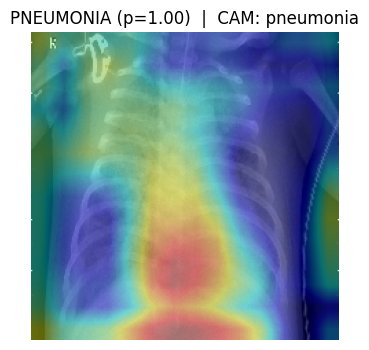

🗂️  Disimpan : person1000_bacteria_2931_pneumonia_PNEUMONIA_p1.00.png


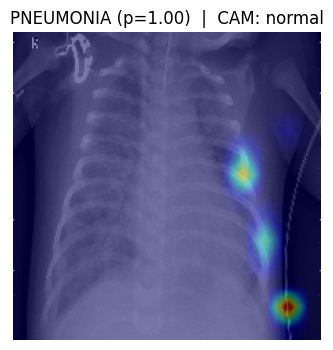

🗂️  Disimpan : person1000_bacteria_2931_normal_PNEUMONIA_p1.00.png


In [ ]:
img_path = '/content/drive/MyDrive/chest_xray_dataset/PNEUMONIA/person1000_bacteria_2931.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


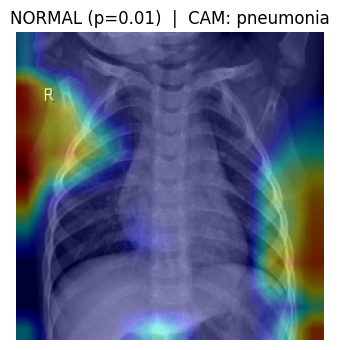

🗂️  Disimpan : normal_pneumonia_NORMAL_p0.01.png


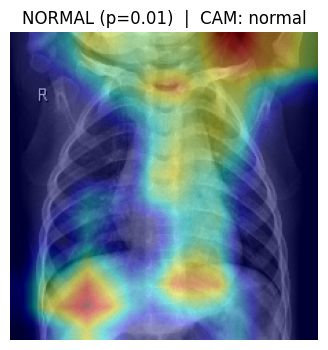

🗂️  Disimpan : normal_normal_NORMAL_p0.01.png


In [ ]:
img_path = '/content/drive/MyDrive/normal.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)

In [ ]:
#──────────── 0. Persiapan ────────────────────────────────────────────────
from google.colab import drive; drive.mount('/content/drive')
import pathlib, random, pandas as pd, cv2, tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from sklearn.utils import shuffle

# <<< GANTI DENGAN PATH TEST FOLDER >>>
test_root = pathlib.Path('/content/drive/MyDrive/chest_xray_dataset/split/test')
assert test_root.exists(), "Folder test tidak ditemukan!"

IMG_SIZE = (224, 224)

#──────────── 1. Memilih 6 contoh (3 normal + 3 pneumonia) ───────────────
normal_imgs    = list((test_root / 'NORMAL').glob('*.jpeg'))
pneumonia_imgs = list((test_root / 'PNEUMONIA').glob('*.jpeg'))

sample_imgs = random.sample(normal_imgs, 3) + random.sample(pneumonia_imgs, 3)
sample_imgs = shuffle(sample_imgs, random_state=42)  # campur

#──────────── 2. Fungsi get_gradcam & predict_image (versi ringkas) ──────
def get_gradcam(model, img_batch, cam_type='pneumonia', layer_name='block5_conv3'):
    grad_model = tf.keras.Model(inputs=model.inputs,
                                outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)
        p = preds[:,0]
        loss = p if cam_type=='pneumonia' else (1.0 - p)
    grads = tape.gradient(loss, conv_out)[0]
    fmap  = conv_out[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.maximum(np.dot(fmap, weights), 0)
    cam = cv2.resize(cam / (cam.max()+1e-8), IMG_SIZE)
    return cam

drive_dir = pathlib.Path('/content/drive/MyDrive/ModelCNN/GradCAM_Lampiran')
drive_dir.mkdir(parents=True, exist_ok=True)

rows = []

for img_path in sample_imgs:
    # --- load + predict ---
    pil = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(pil)/255.0
    arr_b = np.expand_dims(arr, 0)
    prob = float(model.predict(arr_b, verbose=0)[0][0])
    pred_label = 'PNEUMONIA' if prob>0.5 else 'NORMAL'
    true_label = img_path.parent.name.upper()

    for ct in ['pneumonia','normal']:
        cam   = get_gradcam(model, arr_b, cam_type=ct)
        cam_u = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(pil), cv2.COLOR_RGB2BGR),
                                  0.6, cam_u, 0.4, 0)
        outname = f"{img_path.stem}_{ct}.png"
        cv2.imwrite(str(drive_dir/outname), overlay)

    # tambahkan ke tabel
    rows.append(dict(
        filename = img_path.name,
        ground_truth = true_label,
        predicted    = pred_label,
        probability  = round(prob,2),
        overlay_pos  = f"{drive_dir}/{img_path.stem}_pneumonia.png",
        overlay_neg  = f"{drive_dir}/{img_path.stem}_normal.png"
    ))

#──────────── 3. Tabel ringkasan ─────────────────────────────────────────
df = pd.DataFrame(rows)
print(df)                 # tampil di console
df.to_csv(drive_dir/'ringkasan_gradcam.csv', index=False)
print(f"\n📁 Semua file & tabel tersimpan di: {drive_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        filename ground_truth  predicted  probability  \
0              IM-0109-0001.jpeg       NORMAL  PNEUMONIA         0.72   
1      NORMAL2-IM-0651-0001.jpeg       NORMAL     NORMAL         0.09   
2  person1400_bacteria_3550.jpeg    PNEUMONIA  PNEUMONIA         0.99   
3              IM-0280-0001.jpeg       NORMAL     NORMAL         0.00   
4       person466_virus_960.jpeg    PNEUMONIA  PNEUMONIA         0.99   
5     person1599_virus_2775.jpeg    PNEUMONIA  PNEUMONIA         0.95   

                                         overlay_pos  \
0  /content/drive/MyDrive/ModelCNN/GradCAM_Lampir...   
1  /content/drive/MyDrive/ModelCNN/GradCAM_Lampir...   
2  /content/drive/MyDrive/ModelCNN/GradCAM_Lampir...   
3  /content/drive/MyDrive/ModelCNN/GradCAM_Lampir...   
4  /content/drive/MyDrive/ModelCNN/GradCAM_Lampir...   
5  /content/drive/MyDri